# Real-Time Location System Case Study

## Team Names:
David Samuel, Brian West, Kumar Raja

This notebook will explore a Real Time Location System developed to accurately predict device locations indoors, using wifi signal strength.  Our team will examine, format, and clean the data; and then perform a K-Nearest-Neighbors analysis using the signal strength and location data to predict the need for using data from two conflicting wireless access point addresses.

## References

K-Nearest-Neighbor Analysis of Received Signal Strength Distance Estimation Across Environments
Aaron Ault, Xuan Zhong, Edward J. Coyle The Center for Wireless Systems and Applications Purdue University, West Lafayette, Indiana 47907 Email: {ault,zhongx,coyle}@ecn.purdue.edu

https://s3-us-west-2.amazonaws.com/smu-mds/prod/Quantifying+the+World/Course+Materials/WiNMee_Ault.pdf


LOCATION ESTIMATION IN WIRELESS NETWORKS: A BAYESIAN APPROACH
David Madigan1,2, Wen-Hua Ju2, P. Krishnan2, A. S. Krishnakumar2 and Ivan Zorych1
1Rutgers University and 2Avaya Labs Research

https://s3-us-west-2.amazonaws.com/smu-mds/prod/Quantifying+the+World/Course+Materials/A16n210.pdf


Weighted Least Squares Techniques for Improved Received Signal Strength Based Localization
Paula Tarr ́ıo ⋆, Ana M. Bernardos and Jose ́ R. Casar
Data Processing and Simulation Group, Universidad Polite ́cnica de Madrid, ETSI. Telecomunicacio ́n, Avda. Complutense 30, 28040 Madrid, Spain; E-Mails: abernardos@grpss.ssr.upm.es (A.M.B.); jramon@grpss.ssr.upm.es (J.R.C.)

https://s3-us-west-2.amazonaws.com/smu-mds/prod/Quantifying+the+World/Course+Materials/sensors-11-08569.pdf

Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving (Chapman & Hall/CRC The R Series) 1st Edition
Nolan, and Lang

# Get the data

In [13]:
import requests
response = requests.get('http://rdatasciencecases.org/Data/offline.final.trace.txt')

# Start processing data

The data is not in a very convenient format. The first step is to strip out any blank lines or documentation lines (which start with a "#" symbol).

Then we split each line by the semicolons, which delimit the different values in the single observation.

In [14]:
df = response.text.split('\n')
df = list(filter(lambda x: (not x.startswith('#')) and (not len(x) == 0), df))

df = [row.split(';') for row in df]
df[0]

['t=1139643118358',
 'id=00:02:2D:21:0F:33',
 'pos=0.0,0.0,0.0',
 'degree=0.0',
 '00:14:bf:b1:97:8a=-38,2437000000,3',
 '00:14:bf:b1:97:90=-56,2427000000,3',
 '00:0f:a3:39:e1:c0=-53,2462000000,3',
 '00:14:bf:b1:97:8d=-65,2442000000,3',
 '00:14:bf:b1:97:81=-65,2422000000,3',
 '00:14:bf:3b:c7:c6=-66,2432000000,3',
 '00:0f:a3:39:dd:cd=-75,2412000000,3',
 '00:0f:a3:39:e0:4b=-78,2462000000,3',
 '00:0f:a3:39:e2:10=-87,2437000000,3',
 '02:64:fb:68:52:e6=-88,2447000000,1',
 '02:00:42:55:31:00=-84,2457000000,1']

# Filtering out the MAC addresses

As stated in the textbook, each line contains a timestamp (which serves as a unique identifier), a MAC address indicating the ID of the object itself, the position of the object itself at the time the observation was recorded, its orientation in space, and then all observed signals it could see.

However, the number of observed signals is variable for each record, so the number of "columns" is inconsistent, and the order is not the same between each record. So we need to find the unique MAC addresses and how often each one appears.

In [15]:
macs = set(mac.split('=')[0].lower() for row in df for mac in row[4:])
print('There are %d unique MACs in the dataset' % len(macs))
macs

There are 21 unique MACs in the dataset


{'00:04:0e:5c:23:fc',
 '00:0f:a3:39:dd:cd',
 '00:0f:a3:39:e0:4b',
 '00:0f:a3:39:e1:c0',
 '00:0f:a3:39:e2:10',
 '00:14:bf:3b:c7:c6',
 '00:14:bf:b1:97:81',
 '00:14:bf:b1:97:8a',
 '00:14:bf:b1:97:8d',
 '00:14:bf:b1:97:90',
 '00:30:bd:f8:7f:c5',
 '00:e0:63:82:8b:a9',
 '02:00:42:55:31:00',
 '02:0a:3d:06:94:88',
 '02:2e:58:22:f1:ac',
 '02:37:fd:3b:54:b5',
 '02:42:1c:4e:b5:c0',
 '02:4f:99:43:30:cd',
 '02:5c:e0:50:49:de',
 '02:64:fb:68:52:e6',
 '02:b7:00:bb:a9:35'}

Now that we know which unique MAC addresses appear, we need to know the frequency of each one.

In [16]:
mac_counts = []

for mac in macs:
    count = 0
    for mac_id in mac:
        if mac in mac_id:
            count += 1
    mac_counts.append((mac, count))
    
mac_counts = sorted(mac_counts, key=lambda x: x[1], reverse=True)
mac_counts

[('02:b7:00:bb:a9:35', 0),
 ('00:e0:63:82:8b:a9', 0),
 ('02:37:fd:3b:54:b5', 0),
 ('00:14:bf:b1:97:90', 0),
 ('00:0f:a3:39:dd:cd', 0),
 ('02:00:42:55:31:00', 0),
 ('00:14:bf:b1:97:81', 0),
 ('02:2e:58:22:f1:ac', 0),
 ('00:14:bf:b1:97:8a', 0),
 ('00:0f:a3:39:e0:4b', 0),
 ('00:0f:a3:39:e2:10', 0),
 ('02:4f:99:43:30:cd', 0),
 ('00:14:bf:3b:c7:c6', 0),
 ('02:42:1c:4e:b5:c0', 0),
 ('00:0f:a3:39:e1:c0', 0),
 ('02:5c:e0:50:49:de', 0),
 ('02:64:fb:68:52:e6', 0),
 ('00:14:bf:b1:97:8d', 0),
 ('00:30:bd:f8:7f:c5', 0),
 ('02:0a:3d:06:94:88', 0),
 ('00:04:0e:5c:23:fc', 0)]

We will ignore MACs that are not frequent and only take the 7 most common MACs, which are the ones the case study assignment refers us to use. We will later filter these down further to determine which 6 of the 7 perform best, because the desired use case will only utilize 6 total beacons.

In [17]:
macs = [mac for mac, count in mac_counts[:7]]
macs

['02:b7:00:bb:a9:35',
 '00:e0:63:82:8b:a9',
 '02:37:fd:3b:54:b5',
 '00:14:bf:b1:97:90',
 '00:0f:a3:39:dd:cd',
 '02:00:42:55:31:00',
 '00:14:bf:b1:97:81']

# Find the signal strengths for the valid MAC addresses

Now we need to create a dictionary for each record to determine the MACs that it observes. We will then use this to construct a matrix of signal strengths for the 7 beacons we will use for positioning.

In [18]:
signals = [{signal.split('=')[0]: float(signal.split('=')[1].split(',')[0]) for signal in row[4:]} for row in df]
signals[0]

{'00:0f:a3:39:dd:cd': -75.0,
 '00:0f:a3:39:e0:4b': -78.0,
 '00:0f:a3:39:e1:c0': -53.0,
 '00:0f:a3:39:e2:10': -87.0,
 '00:14:bf:3b:c7:c6': -66.0,
 '00:14:bf:b1:97:81': -65.0,
 '00:14:bf:b1:97:8a': -38.0,
 '00:14:bf:b1:97:8d': -65.0,
 '00:14:bf:b1:97:90': -56.0,
 '02:00:42:55:31:00': -84.0,
 '02:64:fb:68:52:e6': -88.0}

Now we iterate through each recorded observation and fill a row in our new matrix with the proper values. This will place NaN for any signal that is not seen for that record. We will later replace these NaNs with an extremely low (-120) signal value.

In [19]:
import numpy as np

o_xs = []
for row in signals:
    x = [row[mac] if mac in row else np.nan for mac in macs]
    o_xs.append(x)
    

o_xs = np.array(o_xs)
print('Shape: {}'.format(o_xs.shape))
o_xs

Shape: (146080, 7)


array([[ nan,  nan,  nan, ..., -75., -84., -65.],
       [ nan,  nan,  nan, ..., -73., -85., -66.],
       [ nan,  nan,  nan, ..., -65.,  nan, -66.],
       ..., 
       [-73.,  nan,  nan, ..., -77.,  nan, -62.],
       [-73.,  nan,  nan, ..., -77.,  nan, -60.],
       [-72.,  nan,  nan, ..., -76.,  nan, -60.]])

The next thing that we are interested in is how many of these records have no recorded signal?

In [21]:
bad_rows = []

count = 0
for i, x in enumerate(o_xs):
    if sum(np.isnan(x)) == 7:
        bad_rows.append(i)
        count += 1

count

59

# Valid positions

Once we have the signals, we need to know the true position at the time of the observation. This is simple as the structure of the position entry is simply: `pos=<x>,<y>,<z>`

In [22]:
positions = []
for row in df:
    new_pos = tuple(float(v) for v in row[2].split('=')[1].split(','))
    positions.append(new_pos)

# Timestamps

It is also convenient to have a unique identifier for each row, so we also pull this information from the original data.

In [23]:
timestamps = [[int(row[0].split('=')[1])] for row in df]
timestamps[0:5]

[[1139643118358],
 [1139643118744],
 [1139643119002],
 [1139643119263],
 [1139643119538]]

# Create Xs dataset

Now that we have created each individual value, we need to merge these into a larger matrix containing record observations with a unique ID, the x/y/z coordinates, and the observed signal strengths.

In [24]:
xs = np.concatenate([timestamps, positions, o_xs], axis=1)
orig_shape = xs.shape
xs.shape

(146080, 11)

We know that we have some NaN values, but before we simply replace them with a very weak signal, we need to know what the strongest and weakest observed (non-NaN) signals are.

In [25]:
print('Min signal: {}'.format(min(xs[:,-7:].reshape(-1))))
print('Max signal: {}'.format(max(xs[:,-7:].reshape(-1))))

Min signal: nan
Max signal: nan


Since the weakest actually observed signal is -98, we cannot truly say that an unobserved signal is -999 because it would then unduly influence the distance from the training points when running the model. Therefore, we chose to replace NaN values with a reasonably weak signal of -120.

In [26]:
xs.reshape(-1)[np.isnan(xs.reshape(-1))] = -120
xs.reshape(-1)[np.isnan(xs.reshape(-1))]

array([], dtype=float64)

In [27]:
xs

array([[  1.13964312e+12,   0.00000000e+00,   0.00000000e+00, ...,
         -7.50000000e+01,  -8.40000000e+01,  -6.50000000e+01],
       [  1.13964312e+12,   0.00000000e+00,   0.00000000e+00, ...,
         -7.30000000e+01,  -8.50000000e+01,  -6.60000000e+01],
       [  1.13964312e+12,   0.00000000e+00,   0.00000000e+00, ...,
         -6.50000000e+01,  -1.20000000e+02,  -6.60000000e+01],
       ..., 
       [  1.14193687e+12,   2.00000000e+01,   8.00000000e+00, ...,
         -7.70000000e+01,  -1.20000000e+02,  -6.20000000e+01],
       [  1.14193687e+12,   2.00000000e+01,   8.00000000e+00, ...,
         -7.70000000e+01,  -1.20000000e+02,  -6.00000000e+01],
       [  1.14193687e+12,   2.00000000e+01,   8.00000000e+00, ...,
         -7.60000000e+01,  -1.20000000e+02,  -6.00000000e+01]])

# Create scoring system

The next step is to create an arbitrary scoring class that can take in a set of training data to check against when predicting the location of a new point based on its observed signals.

This will compute the Euclidean distance of the new record from each of the training records and find the `k` nearest records. It will then use a distance-weighted average of the neighbors' positions in order to derive its location prediction.

In [28]:
class Scorer(object):
    def __init__(self, train_set):
        self.train_set = train_set

    def score(self, signals, *args, k=4):
        signals = np.array(signals)
        signals[np.isnan(signals)] = -120
        signals = signals.reshape((1, 7))

        # Euclidean distance from the observed signal strengths
        distances = (self.train_set[:,-7:] - signals)**2
        distances = np.sqrt(distances.sum(axis=1))

        # Get the k nearest neighbors
        neighbors = np.argpartition(distances, k)

        # Get the positions of the nearby neighbors
        nearest_pos = self.train_set[neighbors[:k], 1:4]

        # Get the k-nearest distance weighted guess of position
        weights = 1 / distances[:k]
        best_guess = (nearest_pos * weights.reshape(-1, 1)).sum(axis=0)
        best_guess /= weights.sum()

        return best_guess

Example usage of the scoring algorithm:

In [29]:
Scorer(xs).score([0, 0, 0, 0, 0, 0, 0])

array([ 18.,   8.,   0.])

# Test the scoring system

In this test, we are using all 7 beacons rather than limmiting us to 6. This is used to derive an overall baseline for accuracy.

In [30]:
import seaborn as sns

In [31]:
def conduct_test(xs):
    np.random.shuffle(xs)
    
    train_xs = xs[:int(xs.shape[0] * 0.8)]
    test_xs = xs[int(xs.shape[0] * 0.8):][0:200]
    
    scorer = Scorer(train_xs)
    
    predicted = np.array([scorer.score(x[-7:]) for x in test_xs])
    euclid_error = np.sqrt((test_xs[:, 1:4] - predicted)**2).sum(axis=1)
    
    return euclid_error

Average error: 3.818727120373623


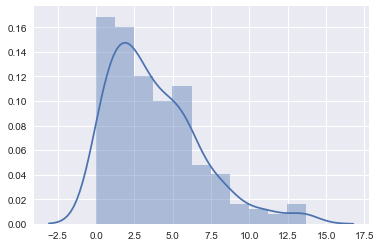

In [32]:
euclid_error = conduct_test(xs)
print('Average error: {}'.format(euclid_error.mean()))

%matplotlib inline
sns.distplot(euclid_error)

This shows the distribution of errors that we observed out of 200 test predictions. The average error was 2.59 feet, but it is right-skewed, which means that the majority of predictions were more accurate than that.

# Pure guessing test

This test shows the error if we were to simply guess that all records are located at the average position of the training data.

Average error: 3.72711353073478


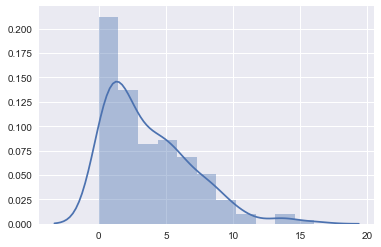

In [34]:
euclid_error = conduct_test(xs)
print('Average error: {}'.format(euclid_error.mean()))

%matplotlib inline
sns.distplot(euclid_error)

We can see that the random guess predictions are extremely inaccurate and do not show any tendency toward 0, as we see in the KNN prediction model.

# Removing selected beacons

As per the case study requirements, we are to determine which MAC works better for location prediction: `00:0f:a3:39:e1:c0` or `00:0f:a3:39:dd:cd`. To do this, we use a modified version of the earlier Scorer class that will only use 6 observed signals per record rather than 7.

In [35]:
class Scorer(object):
    def __init__(self, train_set):
        self.train_set = train_set

    def score(self, signals, *args, k=4):
        signals = np.array(signals)
        signals[np.isnan(signals)] = -120
        signals = signals.reshape((1, 6))

        # Euclidean distance from the observed signal strengths
        distances = (self.train_set[:,-6:] - signals)**2
        distances = np.sqrt(distances.sum(axis=1))

        # Get the k nearest neighbors
        neighbors = np.argpartition(distances, k)

        # Get the positions of the nearby neighbors
        nearest_pos = self.train_set[neighbors[:k], 1:4]

        # Get the k-nearest distance weighted guess of position
        weights = 1 / distances[:k]
        best_guess = (nearest_pos * weights.reshape(-1, 1)).sum(axis=0)
        best_guess /= weights.sum()

        return best_guess

In [36]:
def conduct_test(xs):
    np.random.shuffle(xs)
    
    train_xs = xs[:int(xs.shape[0] * 0.8)]
    test_xs = xs[int(xs.shape[0] * 0.8):][0:200]
    
    scorer = Scorer(train_xs)
    
    predicted = np.array([scorer.score(x[-6:]) for x in test_xs])
    euclid_error = np.sqrt((test_xs[:, 1:4] - predicted)**2).sum(axis=1)
    
    return euclid_error

## Removing MAC 00:0f:a3:39:e1:c0

In [37]:
valid_macs = [i for i, mac in enumerate(macs) if mac != '00:0f:a3:39:e1:c0']
valid_macs

[0, 1, 2, 3, 4, 5, 6]

In [38]:
valid_indices = list(range(0, 4)) + [4 + i for i in valid_macs]
valid_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Average error: 3.7710509915354193


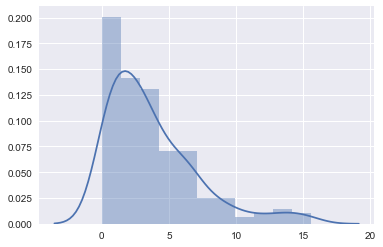

In [39]:
euclid_error = conduct_test(xs[:,valid_indices])
print('Average error: {}'.format(euclid_error.mean()))

%matplotlib inline
sns.distplot(euclid_error)

## Removing MAC 00:0f:a3:39:dd:cd

In [40]:
valid_macs = [i for i, mac in enumerate(macs) if mac != '00:0f:a3:39:dd:cd']
valid_macs

[0, 1, 2, 3, 5, 6]

In [41]:
valid_indices = list(range(0, 4)) + [4 + i for i in valid_macs]
valid_indices

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]

Average error: 4.8654998878247095


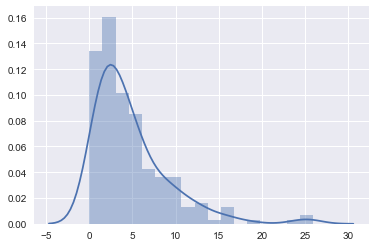

In [42]:
euclid_error = conduct_test(xs[:,valid_indices])
print('Average error: {}'.format(euclid_error.mean()))

%matplotlib inline
sns.distplot(euclid_error)

# Conclusion

It appears that MAC `00:0f:a3:39:e1:c0` is slightly more effective for location prediction than `dd:cd`. While the difference is minor, deleting the former MAC has a more negative impact on prediction accuracy than deleting the latter. That said, the most effective predictions still occur when using all 7 beacons.